# NoSQL (MongoDB) (Ejemplo de Replica Set y Sharding)

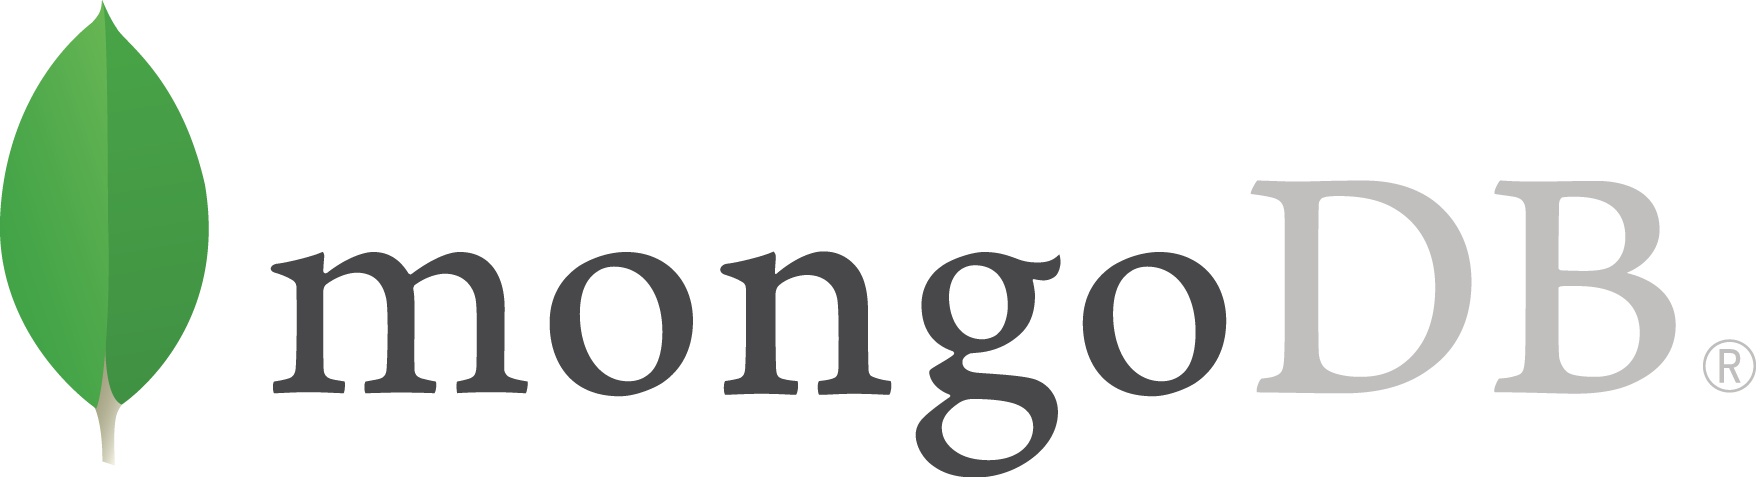

Esta hoja muestra cómo crear un clúster (simulado con `docker-compose` donde se mantienen dos _replica sets_ (conjuntos de réplicas) y una colección (`posts`) que se divide en cada una de esas dos _replica sets_. Al final se indica cómo escalar y añadir más hosts a las _replica sets_.

In [ ]:
!pip install --upgrade pymongo

In [ ]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
%%bash
sudo apt-get update
sudo apt-get install -y mongodb-clients

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [ ]:
%%bash
cat << END | mongo --host mongo_mongocfg1_1
rs.initiate(); // Iniciar el replica set de los servidores de configuración
sleep(1000);
rs.status()
END

In [ ]:
%%bash
cat <<END | mongo --host mongo_mongors1_1
rs.initiate(); // Inicio del RS
sleep(1000);
cfg = rs.conf();
cfg.members[0].host = "mongo_mongors1_1"; // Cambiar el host porque docker coge el hostname del contenedor
rs.reconfig(cfg);  // Reconfigurar
//rs.add(host2/3)  // Añadir posibles nuevos hosts añadidos al RS
rs.status()
END

In [ ]:
%%bash
cat <<END | mongo --host mongo_mongors2_1
rs.initiate();
sleep(1000);
cfg = rs.conf();
cfg.members[0].host = "mongo_mongors2_1";
rs.reconfig(cfg);
//rs.add(host2/3)
rs.status()
END

In [ ]:
import pymongo
from pymongo import MongoClient

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (`mongo`).

In [ ]:
client = MongoClient("mongo_mongors1_1",27017)
client

In [ ]:
client.database_names()

In [ ]:
%%bash
file=../Posts.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
db = client.stackoverflow
db = client['stackoverflow']
db

In [ ]:
posts = db.posts
posts

Importación de los ficheros CSV. Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [ ]:
%%bash
mongoimport --db stackoverflow --collection posts --drop --type csv \
    --headerline --host=mongo_mongors1_1 --file ../Posts.csv

In [ ]:
posts.count()

Creamos el índice por el que se creará el shard. Por defecto es de tipo `ASCENDING`.

In [ ]:
posts.create_index('Id')

Añadimos al _shard_ ambos ordenadores de ambos _replica sets_, y activamos el sharding en la tabla `posts`.

In [ ]:
%%bash
cat <<END | mongo --host mongo_mongos_1
sh.addShard("mongors1/mongo_mongors1_1:27017");
sh.addShard("mongors2/mongo_mongors2_1:27017");
sh.enableSharding("stackoverflow");
sh.shardCollection('stackoverflow.posts', {'Id': 1})
END

In [ ]:
%%bash
cat <<END | mongo --host mongo_mongos_1
sh.status()
END

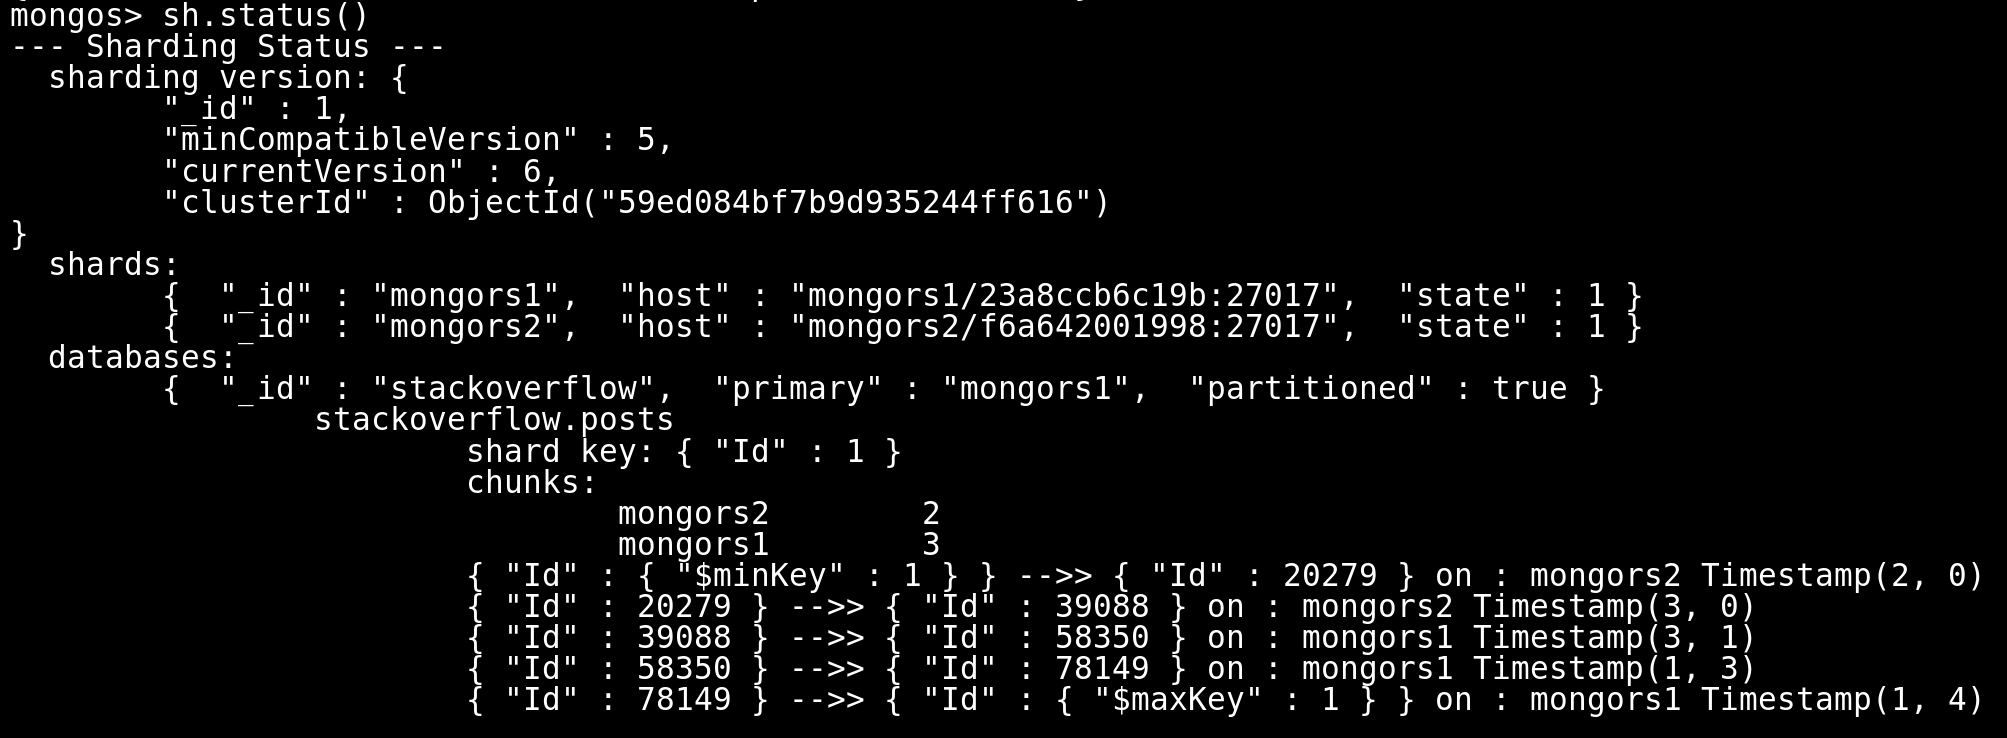

In [ ]:
post = posts.find_one()
post

In [ ]:
posts.find({"PostTypeId": 2}).explain()

# Escalando los _Replica Sets_

Docker (compose) permite de forma muy sencilla hacer crecer y disminuir el número de servidores dedicados a un servicio. En este caso, podemos añadir más hosts virtuales a un _replica set_.

En el _host_ donde se inició el `docker-compose`, se puede aumentar el número de servicios de un replica set:

    $ docker-compose up --scale mongors1=3

Esto crea dos servidores `mongo` en el _replica set_ `mongors1`.

Finalmente, la idea es poder hacer esto en **hosts físicos o virtualizados**, usando de forma similar Docker Swarm o Kubernetes.